# 12. Image registration

Image registration consists in aligning two images so that objects in them can be "aligned". This alignement can occur in space, as for example in the case of tomography where successive stacks are slightly shifted, or in time, for example when there is drift in a time-lapse acquisition.

There are many methods, more or less complicated to do this registration, which can involve shits, rotation and deformation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

from skimage.feature import match_template
from skimage.filters import threshold_otsu

plt.gray()

<Figure size 432x288 with 0 Axes>

In [5]:
image1 = io.imread('Data/channels/channels1.tif')
image2 = io.imread('Data/channels/channels2.tif')

In [6]:
image1 = image1[0:750,:]
image2 = image2[0:750,:]

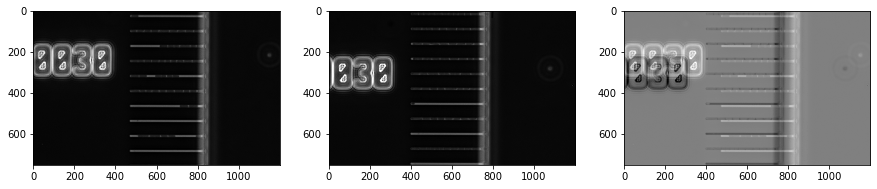

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(image1)
ax[1].imshow(image2)
ax[2].imshow(image1.astype(float)-image2.astype(float));

# 12.1 Simple approach

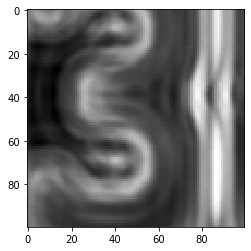

In [21]:
plt.imshow(image1[200:300,200:300]);

In [9]:
matched = match_template(image2, image1[200:300,200:300],pad_input=True)

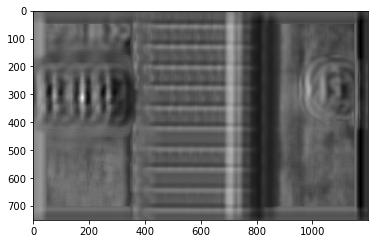

In [20]:
plt.imshow(matched);

In [11]:
maxpos = np.argmax(matched)
maxpos

374576

In [12]:
maxpos = np.unravel_index(maxpos, matched.shape)
maxpos

(312, 176)

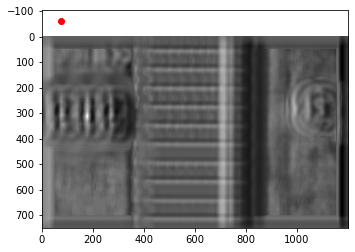

In [19]:
plt.imshow(matched)
plt.plot([maxpos[1]],[maxpos[0]],'ro');

In [14]:
template_center = 250
maxpos = template_center - np.array(maxpos)
maxpos

array([-62,  74])

In [15]:
image2_shift = np.roll(image2,shift = maxpos,axis = (0,1))

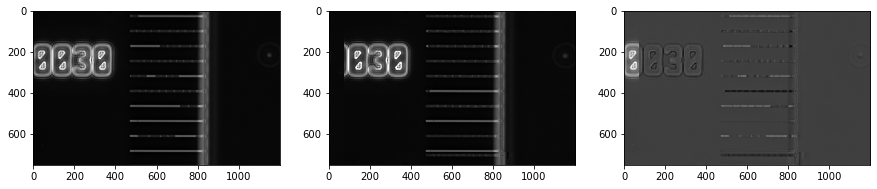

In [18]:
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(image1)
ax[1].imshow(image2_shift)
ax[2].imshow(image1.astype(float)-image2_shift.astype(float));

# 12.2 General approach

In [23]:
from skimage.feature import ORB, match_descriptors, plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform

In [24]:
detector_extractor1 = ORB(n_keypoints=200)
detector_extractor2 = ORB(n_keypoints=200)

In [25]:
detector_extractor1.detect_and_extract(image1)
keypoints1 = detector_extractor1.keypoints
descriptors1 = detector_extractor1.descriptors


detector_extractor2.detect_and_extract(image2)
keypoints2 = detector_extractor2.keypoints
descriptors2 = detector_extractor2.descriptors

In [26]:
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

Text(0.5, 1.0, 'Original Image vs. Transformed Image')

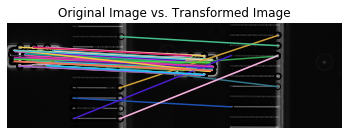

In [27]:
fig, ax = plt.subplots()

plt.gray()

plot_matches(ax, image1, image2, keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Original Image vs. Transformed Image")

In [28]:
coords1 = keypoints1[matches12[:, 0]]
coords2 = keypoints2[matches12[:, 1]]

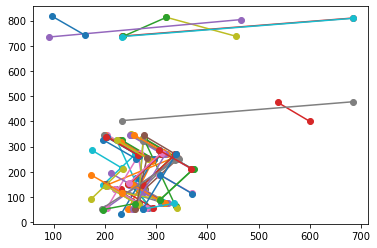

In [29]:
for x1, x2 in zip(coords1, coords2):
    plt.plot([x1[0],x2[0]],[x1[1],x2[1]],'-o')
plt.show()

In [210]:
#coords1 = coords1[(coords1[:,0]<400)&(coords1[:,1]<400),:]
#coords2 = coords2[(coords2[:,0]<400)&(coords2[:,1]<400),:]

In [30]:
model = AffineTransform()
model.estimate(coords1, coords2)

True

In [31]:
print(model.scale, model.translation, model.rotation)


(3.9821515141194355, 1.461939042859838) [-427.31749233  -83.68571398] 0.12738167750904475


In [32]:
model_robust, inliers = ransac((coords1, coords2), AffineTransform, min_samples=3, residual_threshold=0.1)

In [33]:
print(model_robust.scale, model_robust.translation, model_robust.rotation)


(1.00056068406593, 1.0000037409813243) [ 62.99942303 -74.64960778] -5.042032765443701e-09


## 12.3 Fourier transform and rotation

If you have repetitive signal in your image, like here the channels, you can exploit it in your analysis. For example if your image is not clearly horizontal an you want to align it, you can use the power of Fourier transforms to do the job.

A fourier transform is a way to describe any signal as an infinite sum of periodic signals. Very roughly, each component of that sum has an amplitude given by the Fourier transform. In real world application one doesn't have continuous and infinite signals and one has to use an approximate Fourier transform called Fast Fourier Transform or FFT. Naturally this works not just in one dimension but also in two.

Quick 1d reminder:



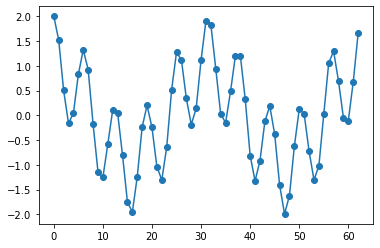

In [34]:
#creaete x positions
x = np.arange(0,10*2*np.pi,1)

#pick frequencies
freq = 0.1
freq2 = 0.5

#generate signal
y = np.cos(2*freq*x) + np.cos(2*freq2*x)

#plot the result
plt.plot(x,y,'-o')
plt.show()

/Users/gw18g940/miniconda3/envs/improc_env/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


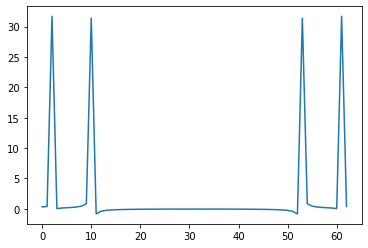

0.1
0.5


In [35]:
from scipy.signal import find_peaks

#fourier transform the signal 
fourier = np.fft.fft(y)

#plot it
plt.plot(fourier)
plt.show()

#find peaks position and recover frequency
print(find_peaks(fourier[0:300])[0][0]/20)
print(find_peaks(fourier[0:300])[0][1]/20)

Now we look at the 2D case. For the purpose of the example, let's focus on the area that contains channels and create a slightly rotated version of one of the images and see how we can use Fourier transforms to correct it.

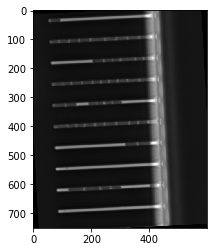

In [36]:
import skimage.transform

angle = 3
image_rotate = image1[:,400:1000]
image_rotate = skimage.transform.rotate(image_rotate,angle,cval=0)

plt.imshow(image_rotate)
plt.show()

To avoid confusions with dimensions, let's make the image square by padding it.

In [37]:
image_pad = np.pad(image_rotate,((0,0),(image_rotate.shape[0]-image_rotate.shape[1],0)),mode = 'constant',constant_values = 0)


Now we take the 2D transform of the signal and plot it. We also shift use a shifting function so that low frequency signal ends up in the middle of the image:

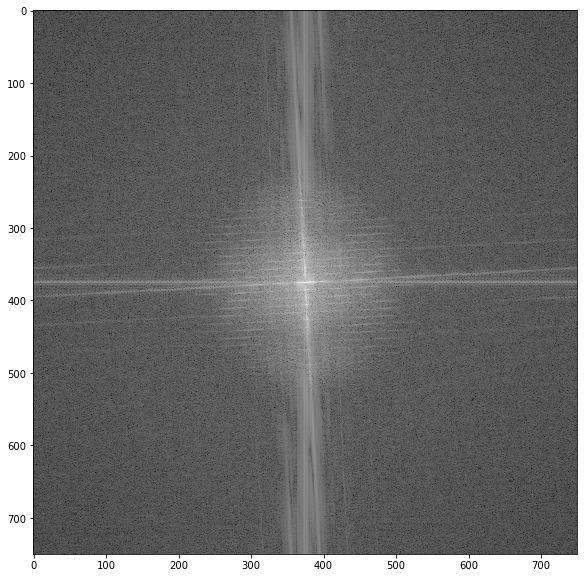

In [38]:
f0 = np.fft.fftshift(np.abs(np.fft.fft2(image_pad)))

plt.figure(figsize=(10,10))
plt.imshow(np.log(f0))
plt.show()

To find the rotation angle, we can now rotate the fourier transform using a range of angles, and project along the vertical axis. Once the cross visible in the middle of the image is aligned, its projection should show the maximal values:

In [39]:
allproj = []

#rotate the fourier transform and do a max projection
for i in np.arange(-10,10,1):
    basicim = skimage.transform.rotate(f0,i,cval=0)

    allproj.append(np.max(np.sum(basicim,axis=0)))

#find maximum angle
angle = np.arange(-10,10,1)[np.argmax(allproj)]

In [40]:
angle

-3